In [1]:
import sys
import os
# Detect if running in Google Colab
if "google.colab" in sys.modules:
    !pip install ultralytics

    # make utils dir
    os.makedirs("/content/src/utils", exist_ok=True)
    !wget -O /content/src/utils/utils.py https://raw.githubusercontent.com/jayyang17/pool_management_system/main/src/utils/utils.py
    !wget -O /content/src/utils/preprocess_utils.py https://raw.githubusercontent.com/jayyang17/pool_management_system/main/src/utils/preprocess_utils.py
    sys.path.append("/content/src")

    # get training data from s3
    os.makedirs("/content/artifact", exist_ok=True)
    !wget aws s3 cp 'https://poolmanagementsystem.s3.ap-southeast-1.amazonaws.com/raw_data/data.zip' -O /content/artifact/data.zip

    # import config from git
    !wget -O /content/config.yaml https://raw.githubusercontent.com/jayyang17/pool_management_system/main/config.yaml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.1/922.1 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [4]:
# Normal import (works in both local & Colab)
import ultralytics
from src.utils.utils import unzip_file, read_yaml, write_yaml, save_model, zip_model
from src.utils.preprocess_utils import process_dataset, augment_images, balance_dataset,create_yolo_data_yaml, split_train_val


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Import Configurations

In [5]:
# config
config = read_yaml('./config.yaml')

In [10]:
import yaml

# Label studio data
RAW_DATA_PATH = config["RAW_DATA_PATH"]

# PATH CONFIGURATIONS
ARTIFACT_DIR      = config["ARTIFACT_DIR"]
ORIGINAL_PATH     = config["ORIGINAL_PATH"]

# Original data paths (from Label Studio)
ORIGINAL_IMG_DIR  = config["ORIGINAL_IMG_DIR"]    # Images from Label Studio
YOLO_LABELS_DIR   = config["YOLO_LABELS_DIR"]     # YOLO labels from Label Studio

# Resized data paths (before augmentation)
RESIZED_IMG_DIR   = config["RESIZED_IMG_DIR"]     # Resized images
RESIZED_LABELS_DIR = config["RESIZED_LABELS_DIR"]    # Updated YOLO labels

# Augmented data paths
AUGMENTED_IMG_DIR   = config["AUGMENTED_IMG_DIR"]     # Augmented images
AUGMENTED_LABELS_DIR = config["AUGMENTED_LABELS_DIR"]   # Augmented YOLO labels

# Target training directories
TRAINING_IMG_DIR   = config["TRAINING_IMG_DIR"]
TRAINING_LABELS_DIR = config["TRAINING_LABELS_DIR"]

# Other paths
SOURCE_TRAIN_DIR  = config["SOURCE_TRAIN_DIR"]
MODEL_OUTPUT_DIR  = config["MODEL_OUTPUT_DIR"]
ZIP_MODEL_PATH    = config["ZIP_MODEL_PATH"]
# DATA_PATH         = config["DATA_PATH"]
CLASSES_TXT_PATH  = config["CLASSES_TXT_PATH"]
DATA_YAML_PATH    = config["MODEL"]["DATA_YAML_PATH"]

# data path for model training
# Determine the base path dynamically, to avoid changing the env
if os.path.exists('/content'):
    # Set the dataset path for Colab
    DATA_PATH = '/content/data'
else:
    # For local
    DATA_PATH = os.path.join(os.getcwd(), 'data')


MODEL_CONFIG = config["MODEL"]
TRAINING_CONFIG = config["TRAINING"]

# Model settings
pretrain_model = MODEL_CONFIG["PRETRAIN_MODEL"]
data_yaml = MODEL_CONFIG["DATA_YAML_PATH"]

# Training parameters
img_size = TRAINING_CONFIG["IMG_SIZE"]
epochs = TRAINING_CONFIG["NUM_EPOCHS"]
batch_size = TRAINING_CONFIG["BATCH_SIZE"]
lr0 = TRAINING_CONFIG["LR0"]
weight_decay = TRAINING_CONFIG["WEIGHT_DECAY"]
patience = TRAINING_CONFIG["PATIENCE"]

# Model output paths
model_output = config["MODEL_OUTPUT_DIR"]
runs_path = config["RUN_PATH"]
model_weights = config["MODEL_WEIGHTS"]

# Training parameters
TRAINING_CONFIG = config["TRAINING"]
NUM_EPOCHS = TRAINING_CONFIG["NUM_EPOCHS"]
IMG_SIZE   = TRAINING_CONFIG["IMG_SIZE"]

# Data splitting ratios
DATA_SPLIT = config["DATA_SPLIT"]
IMG_BALANCE_RATIO = DATA_SPLIT["img_balance_ratio"]
TRAIN_RATIO       = DATA_SPLIT["train_ratio"]

# INFERENCE CONFIGURATIONS
INFERENCE = config["INFERENCE"]
CONF_THRESHOLD = INFERENCE["CONF_THRESHOLD"]
IOU_THRESHOLD  = INFERENCE["IOU_THRESHOLD"]




# Upload Dataset and prepare training data

In [11]:
# unzip the zip file generated from label-studio into the output dir
unzip_file(RAW_DATA_PATH,ORIGINAL_PATH)

Successfully extracted ./artifact/data.zip to ./artifact/original_data


# Preprocess

In [12]:
process_dataset(ORIGINAL_IMG_DIR, RESIZED_IMG_DIR, RESIZED_LABELS_DIR, YOLO_LABELS_DIR)

Processed pinterest-19_jpg.rf.ef0b1b981f8b8976d8bbdda2a6fe0d57.jpg
Processed train-04_png.rf.ca3b439540bf9020a5c9525eb8d9c7ca.jpg
Processed train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg
Processed pinterest-17_jpg.rf.be8a6405061501297491c5dc48ce4c97.jpg
Processed train-05_png.rf.9139c24a5208120e3278d4e7aaf9b1b8.jpg
Processed train-07_png.rf.588b8660db71799422e9f255221198f9.jpg
Processed pinterest-01_jpg.rf.ad8480119674c3f6123d2d061a0dfc44.jpg
Processed train-03_png.rf.da782c83805ae11291f695ff003daebe.jpg
Processed pinterest-04_jpg.rf.3e7d9f90986b4dccb7cabed2f1023bf1.jpg
Processed pinterest-12_jpg.rf.e7c79282f4403830711b1a09433dcf46.jpg
Processed pinterest-15_jpg.rf.5105a1f644e876833001fa4a6edb5c5a.jpg
Processed pinterest-07_jpg.rf.df6d713578885ff1eb07fbca5929e692.jpg
Processed pinterest-11_jpg.rf.98389ab55b22740e1bd60b98a7311ad4.jpg
Processed pinterest-14_jpg.rf.19dc64f82b4406ee0f2e31b4cccde8df.jpg
Processed train-06_png.rf.c7b65d08869dd18038149a7b829c965a.jpg
Processed pinterest

In [13]:
augment_images(RESIZED_IMG_DIR, RESIZED_LABELS_DIR, AUGMENTED_IMG_DIR, AUGMENTED_LABELS_DIR)

Augmented: pinterest-19_jpg.rf.ef0b1b981f8b8976d8bbdda2a6fe0d57.jpg --> aug_pinterest-19_jpg.rf.ef0b1b981f8b8976d8bbdda2a6fe0d57.jpg
Augmented: train-04_png.rf.ca3b439540bf9020a5c9525eb8d9c7ca.jpg --> aug_train-04_png.rf.ca3b439540bf9020a5c9525eb8d9c7ca.jpg
Augmented: train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg --> aug_train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg
Augmented: pinterest-17_jpg.rf.be8a6405061501297491c5dc48ce4c97.jpg --> aug_pinterest-17_jpg.rf.be8a6405061501297491c5dc48ce4c97.jpg
Augmented: train-05_png.rf.9139c24a5208120e3278d4e7aaf9b1b8.jpg --> aug_train-05_png.rf.9139c24a5208120e3278d4e7aaf9b1b8.jpg
Augmented: train-07_png.rf.588b8660db71799422e9f255221198f9.jpg --> aug_train-07_png.rf.588b8660db71799422e9f255221198f9.jpg
Augmented: pinterest-01_jpg.rf.ad8480119674c3f6123d2d061a0dfc44.jpg --> aug_pinterest-01_jpg.rf.ad8480119674c3f6123d2d061a0dfc44.jpg
Augmented: train-03_png.rf.da782c83805ae11291f695ff003daebe.jpg --> aug_train-03_png.rf.da782c83805ae

In [14]:
balance_dataset(
    RESIZED_IMG_DIR,
    RESIZED_LABELS_DIR,
    AUGMENTED_IMG_DIR,
    AUGMENTED_LABELS_DIR,
    TRAINING_IMG_DIR,
    TRAINING_LABELS_DIR,
    ratio_original=IMG_BALANCE_RATIO,
    total_samples=None)


Balanced dataset created with 34 original and 34 augmented images.


## split training and validation

In [15]:
# split training and validation images
split_train_val(TRAINING_IMG_DIR, TRAINING_LABELS_DIR, TRAIN_RATIO)

Found 68 images and 68 labels.
Splitting data: 54 for training, 14 for validation.
Data split complete! Check the 'train/' and 'validation/' folders.


In [16]:
# create the data.yaml file
create_yolo_data_yaml(DATA_PATH, CLASSES_TXT_PATH, DATA_YAML_PATH)

# check the data.yaml file
read_yaml(DATA_YAML_PATH)

YAML file created at ./data.yaml


{'path': '/content/data',
 'train': 'train/images',
 'val': 'validation/images',
 'nc': 2,
 'names': ['occupied', 'empty']}

# Model Training

In [17]:
from ultralytics import YOLO

# Define training parameters
PRETRAIN_MODEL = "yolov8n.pt"       # Pretrained model
DATA_YAML_PATH = "data.yaml"        # Path to data config
IMG_SIZE = 640                      # Standard YOLO input size
EPOCHS = 5                         # Reduce to prevent overfitting
BATCH_SIZE = 16                     # Increase if GPU allows
LR0 = 0.0005                        # Lower LR for more stable training
WEIGHT_DECAY = 0.0001               # Reduce overfitting risk
PATIENCE = 15                       # Keep early stopping but lower patience

# Load YOLO model
model = YOLO(PRETRAIN_MODEL)

# Start training with optimized settings
results = model.train(
    data=DATA_YAML_PATH,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    lr0=LR0,
    weight_decay=WEIGHT_DECAY,
    # patience=PATIENCE
)

print("Training complete!")


100%|██████████| 6.25M/6.25M [00:00<00:00, 48.0MB/s]


Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=

100%|██████████| 755k/755k [00:00<00:00, 21.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 79.3MB/s]


AMP: checks passed ✅


train: Scanning /content/data/train/labels... 54 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<00:00, 2094.24it/s]

train: New cache created: /content/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/validation/labels... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<00:00, 589.26it/s]

val: New cache created: /content/data/validation/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.33G      2.517      3.777      2.008        133        640: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         14        215     0.0102      0.197      0.012    0.00568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       2.2G      2.415      3.672      1.981        125        640: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         14        215     0.0135      0.267     0.0442     0.0235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.27G      2.383      3.544      1.798        133        640: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         14        215     0.0171      0.341      0.067     0.0276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.08G      2.213      3.177      1.673         66        640: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         14        215     0.0242      0.481     0.0977     0.0363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.29G      2.382      2.992      1.677        167        640: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         14        215     0.0245      0.486      0.113     0.0439



5 epochs completed in 0.005 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


                   all         14        215     0.0245      0.486      0.119     0.0459
              occupied         11        109     0.0191      0.349     0.0471      0.012
                 empty         12        106     0.0299      0.623       0.19     0.0798
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train
Training complete!


## Save the best model

In [18]:
# save and zip model
save_model(source_train_dir="/content/runs/detect/train",
               model_weights="best.pt",
               output_dir="/content/model")

zip_model(model_dir="/content/model", zip_path="/content/model_v8m_v6.zip")

Model files saved successfully at: /content/model
Model zipped successfully at: /content/model_v8m_v6.zip


# Test image


image 1/14 /content/data/validation/images/aug_pinterest-01_jpg.rf.ad8480119674c3f6123d2d061a0dfc44.jpg: 640x640 (no detections), 11.0ms
image 2/14 /content/data/validation/images/aug_pinterest-08_jpg.rf.b4972d338e0c6f8d344441751979161d.jpg: 640x640 (no detections), 7.4ms
image 3/14 /content/data/validation/images/aug_pinterest-14_jpg.rf.19dc64f82b4406ee0f2e31b4cccde8df.jpg: 640x640 (no detections), 9.3ms
image 4/14 /content/data/validation/images/aug_pinterest-20_jpg.rf.b7d8c3b7a93e0bce592c08e0f3aeeeeb.jpg: 640x640 (no detections), 7.4ms
image 5/14 /content/data/validation/images/aug_pinterest-23_jpg.rf.252e8093a2cd5f1d985131b992d00e79.jpg: 640x640 (no detections), 7.4ms
image 6/14 /content/data/validation/images/aug_pinterest-25_jpg.rf.a49077860ac4a05bfa1b52d7f327cb05.jpg: 640x640 (no detections), 7.4ms
image 7/14 /content/data/validation/images/aug_train-04_png.rf.ca3b439540bf9020a5c9525eb8d9c7ca.jpg: 640x640 (no detections), 7.4ms
image 8/14 /content/data/validation/images/aug_tra

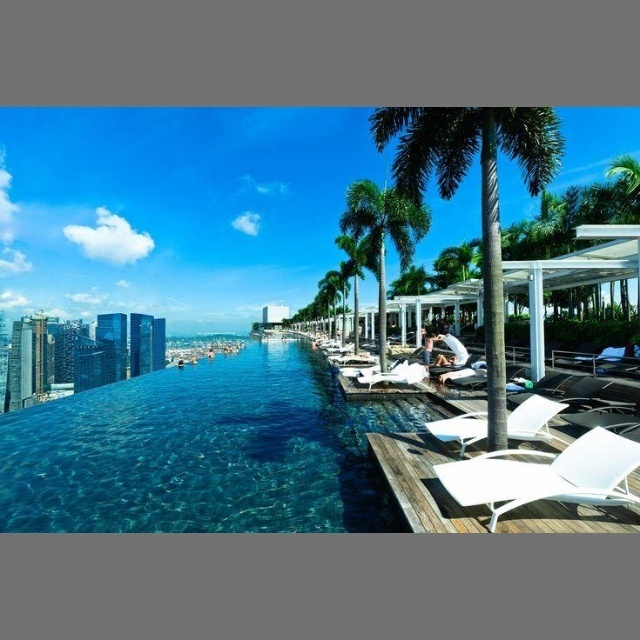

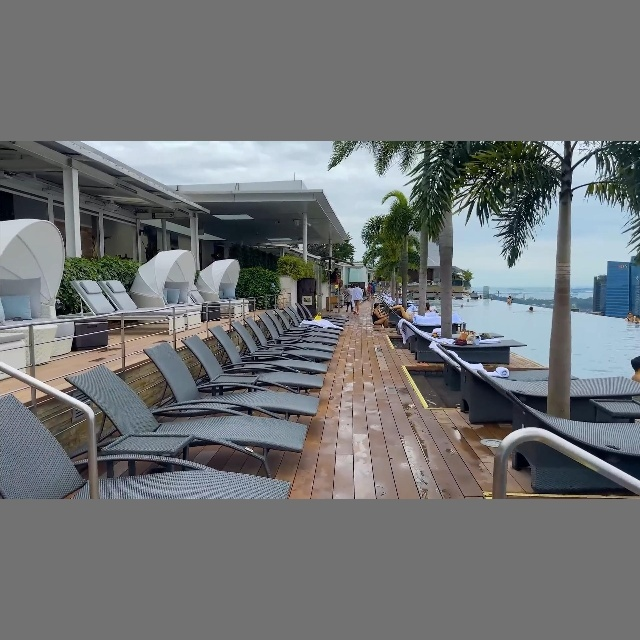

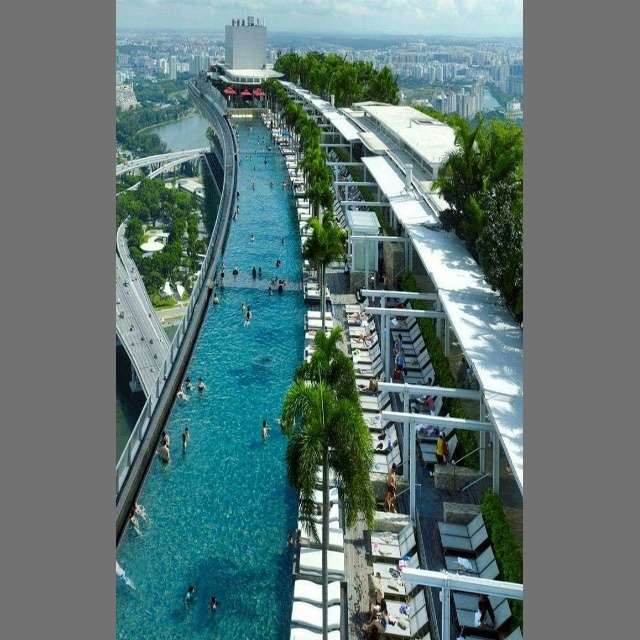

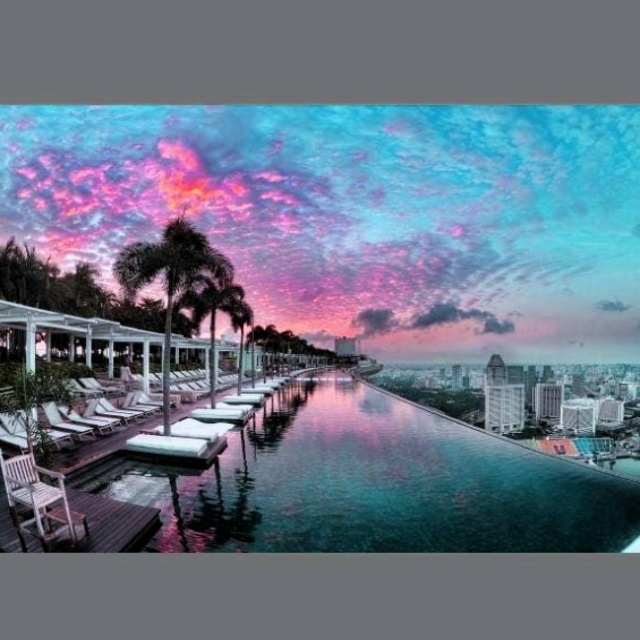

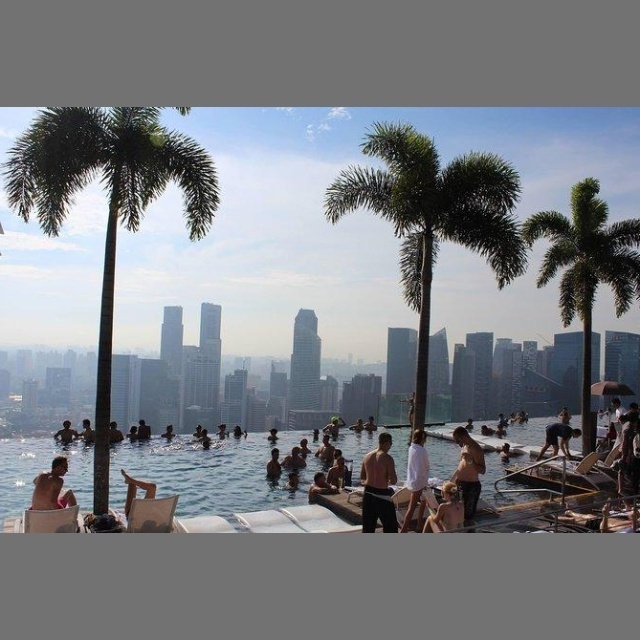

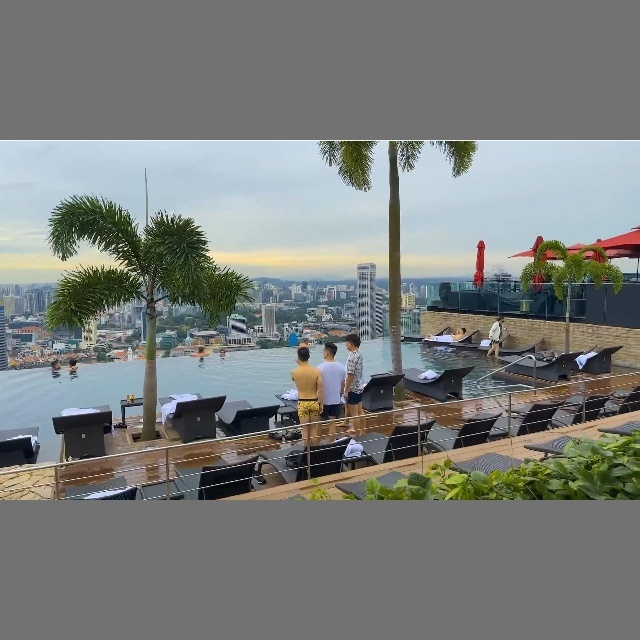

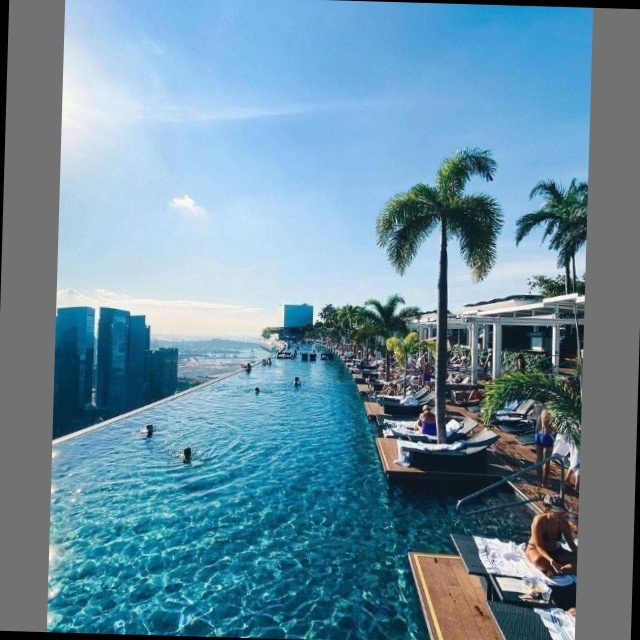

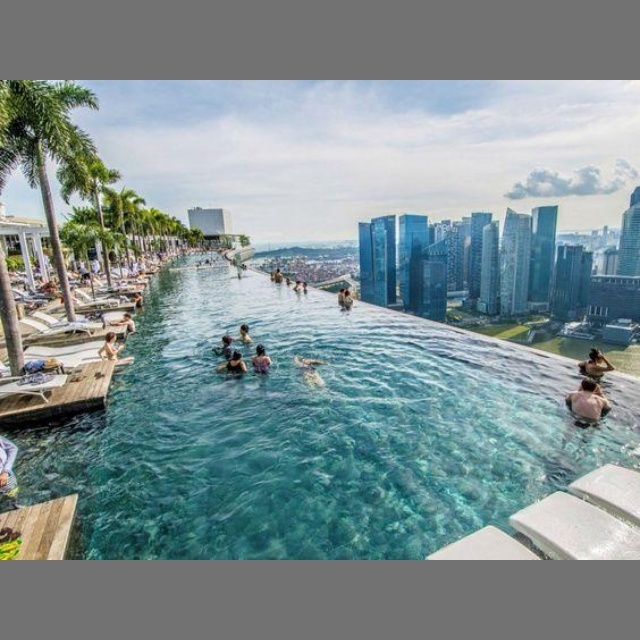

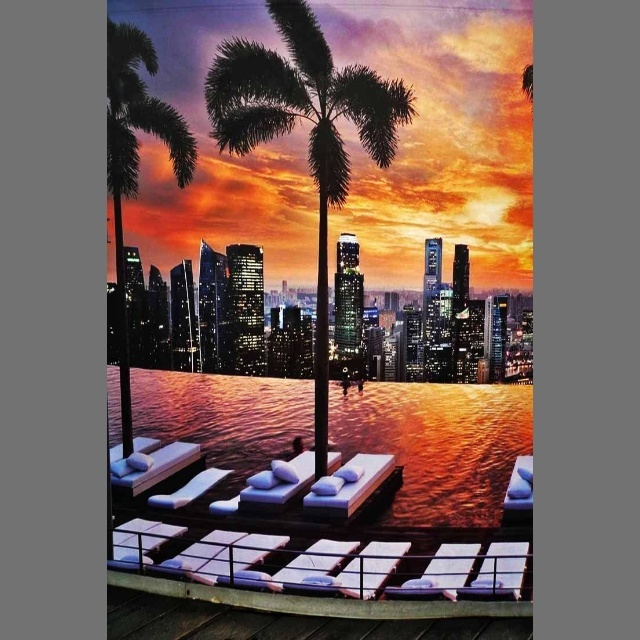

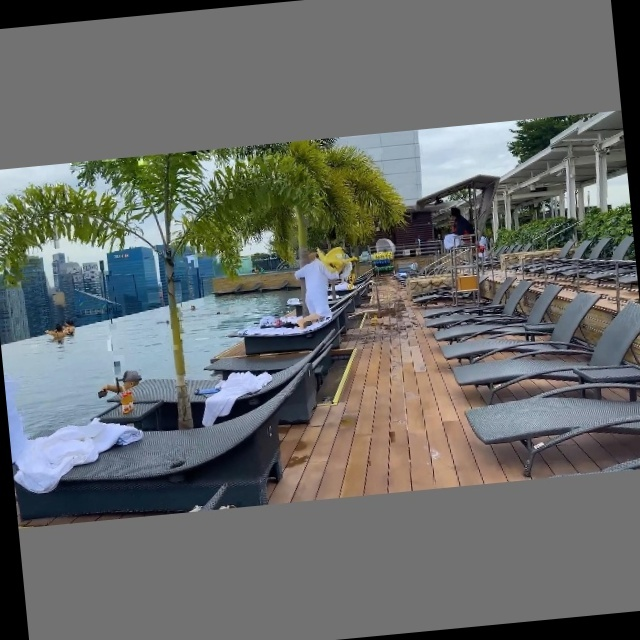

In [19]:
from ultralytics import YOLO

# Load your trained YOLO model
model = YOLO("/content/model/model.pt")  # Update the path if needed


test_image_path = "data/validation/images"
# test_image_path = "/content/artifact/original_data/images"
# Run inference on images in a folder
results = model.predict(source=test_image_path, conf=CONF_THRESHOLD, iou=IOU_THRESHOLD, save=True)
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


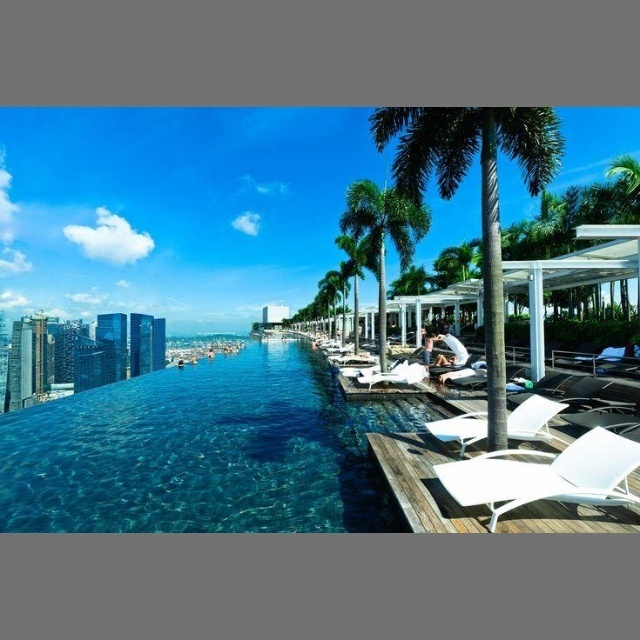

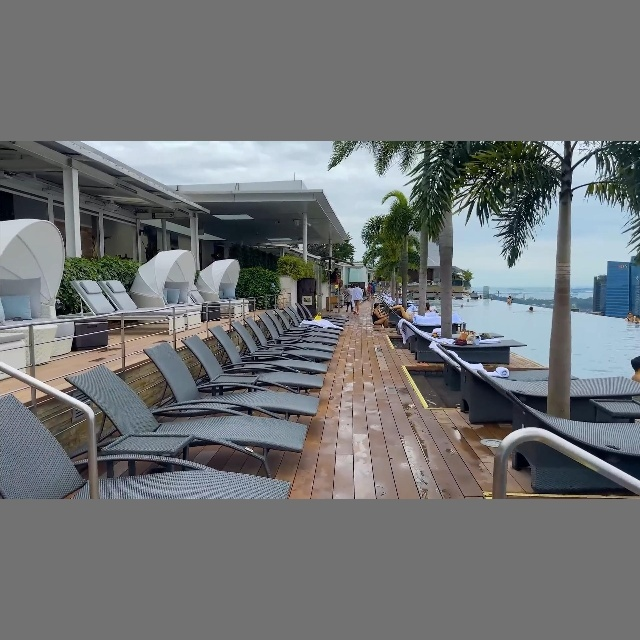

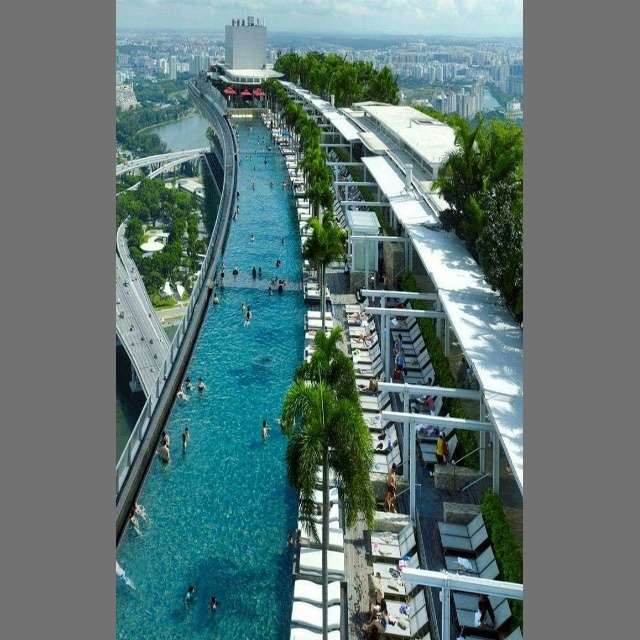

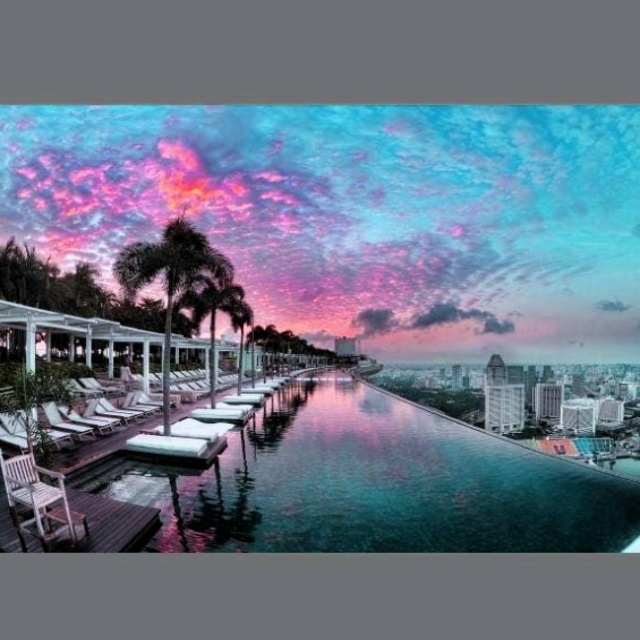

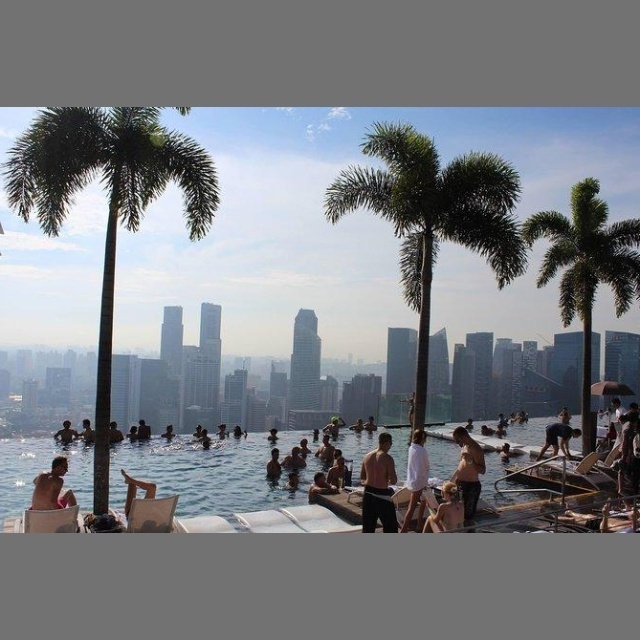

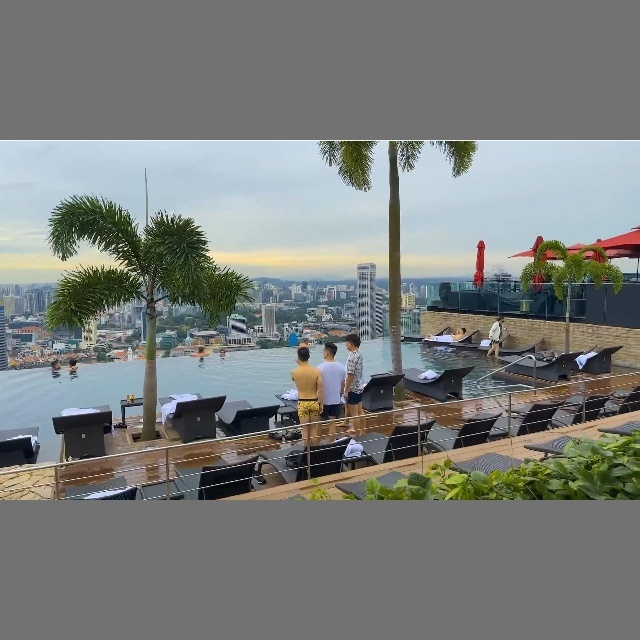

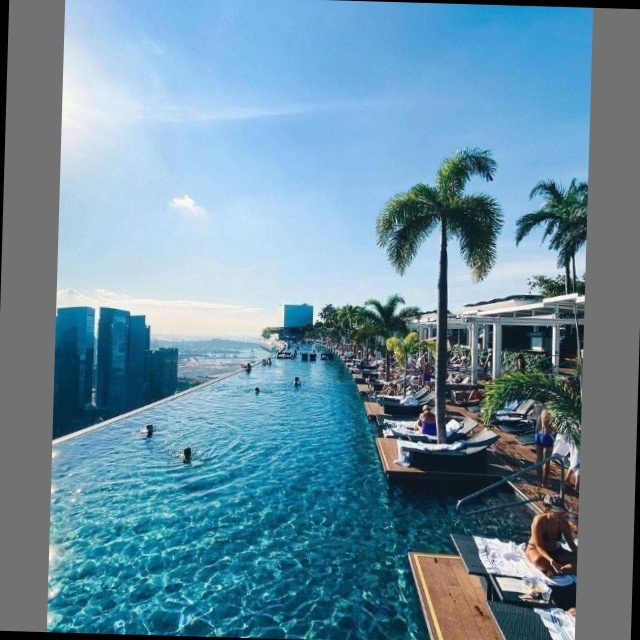

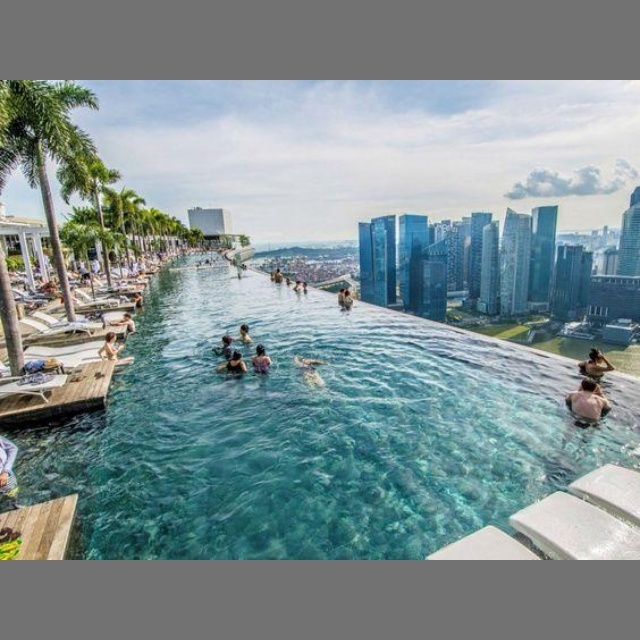

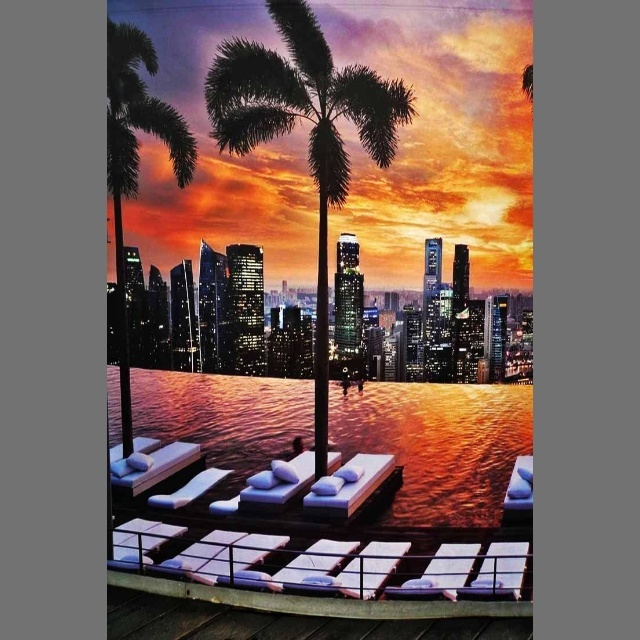

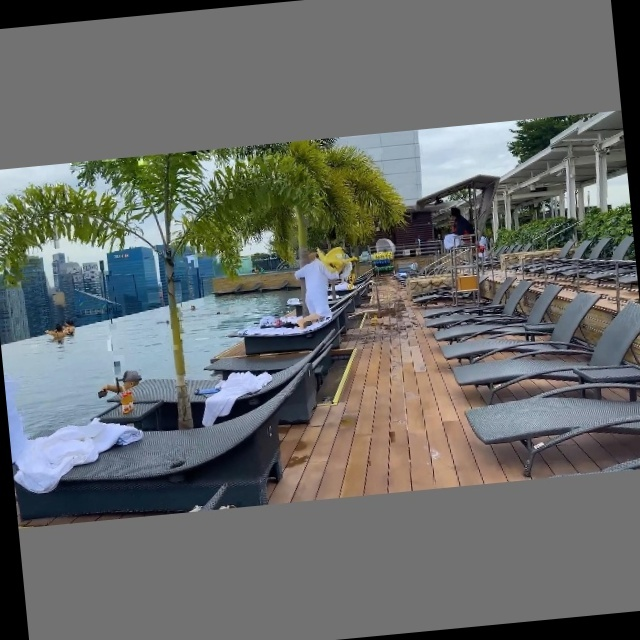

In [20]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


# Inference Step